In [1]:
%load_ext autotime

# Examine Target

This notebook look at some of the properties for a specific target as pulled from the sources listed generated in the [Source Detection](PIAA-Source-Detection-And-Filtering.ipynb) notebook. 

Note that this step is not necessary for the processing of an observation sequence as a whole but instead serves to highlight some of the issues with processing the images in a traditional fashion and thus helps motivate our unique algorithm.

In [2]:
import os

from matplotlib import cm
from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd
from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor
from piaa.utils import noise

from pocs.utils.images import fits as fits_utils
from pocs.utils.google.storage import PanStorage

from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy import units as u

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

time: 3.61 s


## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [12]:
# picid = 435715608
# picid = 287933433
picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?
# picid = 11133916  # Same mag as HD189733
# picid = 86234511
# picid = helpers.get_star_info(twomass_id='20005694+2250490', cursor=tess_cursor).id
# picid = 11135315
# picid = 10777186

star_info = helpers.get_star_info(picid=picid, cursor=tess_cursor)

time: 47.7 ms


In [3]:
twomass = '20004370+2242391'

star_info = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor)
picid = star_info.id  # HD 189733

time: 87.3 ms


In [4]:
print(f'PICID: {picid}')

PICID: 256364928
time: 786 µs


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [4]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
noise_filename = os.path.join(base_dir, f'point-sources-noise.csv')

source_noise = pd.read_csv(noise_filename, parse_dates=['date_obs']).set_index(['date_obs'])

time: 1.88 s


For our target table we want to compare the flux as calculated from `sextractor` (which has no knowledge of the RGB array) with that pulled from a custom stamp.  `sextractor` uses a 6-pixel circular aperture  centered around the calculated centroid (the `x` and `y` values in our `sources` table) while our custom stamps will use an aperture that is sliced according to our rule of having a fixed pixel pattern. Here we use a 6-pixel aperture on our stamps for direct comparison with `sextractor` but the size can be vary.

In [13]:
target_noise = source_noise.loc[source_noise.picid == picid]

time: 3.81 ms


In [14]:
target_noise.tail()

,back,back_noise,channel,counts,dark_noise,noise,photon_noise,picid,readout_noise
date_obs,,,,,,,,,
2018-08-22 07:42:20,866.350000,125.542931,b,9569.250000,50.0,157.129015,79.871772,287511722,175.0
2018-08-22 07:44:07,1407.351648,558.498701,all,28295.835165,200.0,608.961156,137.345878,287511722,700.0
2018-08-22 07:44:07,981.450000,181.603820,r,7088.750000,50.0,200.635941,68.744697,287511722,175.0
2018-08-22 07:44:07,1666.317073,337.030609,g,23261.146341,100.0,373.022871,124.528836,287511722,350.0
2018-08-22 07:44:07,865.800000,108.777571,b,9184.000000,50.0,143.192970,78.247471,287511722,175.0


time: 16.3 ms


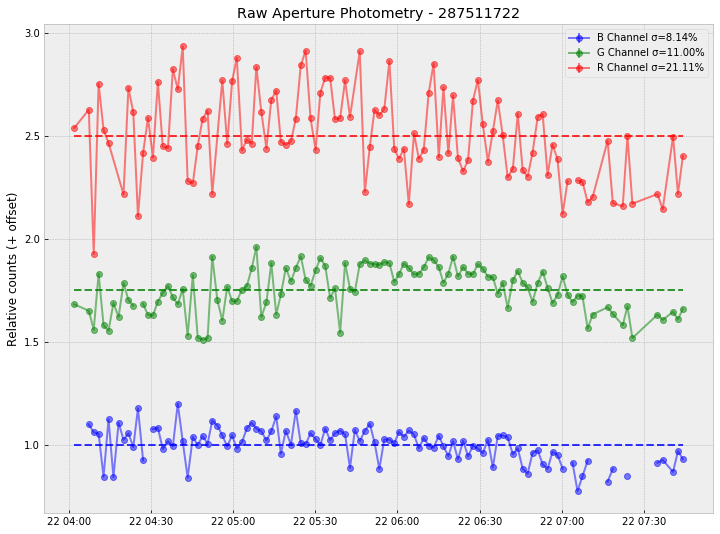

time: 1.62 s


In [15]:
plt.figure(figsize=(12, 9))

for i, color in enumerate('bgr'):
    color_data = target_noise.loc[target_noise.channel == color]
    
    clipped_counts = sigma_clip(color_data.counts, sigma=3)

    counts_mean = clipped_counts.mean()
    
    counts_z = clipped_counts / counts_mean
    counts_std = clipped_counts.std() / counts_mean
    
    # Add the noise
    color_noise = color_data.noise / counts_mean
    
    c_noise = np.ma.array(color_noise, mask=clipped_counts.mask) / counts_mean

    offset = i * 0.75
    counts_z += offset
    
    plt.hlines(counts_z.mean(), color_data.index[0], color_data.index[-1], color=color, linestyles='dashed', alpha=0.8)
    plt.errorbar(color_data.index, counts_z, yerr=c_noise, color=color, alpha=0.5, marker='o', ls='-', label=f'{color.upper()} Channel σ={counts_std:.02%}')
    
plt.ylabel('Relative counts (+ offset)')
plt.title(f'Raw Aperture Photometry - {picid}')
plt.legend()
plt.savefig(os.path.join(base_dir, 'stamps', f'aperture-sums-{picid}.png'), transparent=False, dpi=100)
plt.savefig(f'aperture-photometry.png', transparent=False, dpi=100)

As we can see, the spread in the light curve is fairly large with straight aperture photometry for all channels. The goal for our algorithm is to reduce this spread to the percent level. 

However, before looking at our algorithm it is worthwhile to look at traditional [differential photometry](PIAA-Diff-Photometry.ipynb) results to see how they compare.